In [1]:
using Revise, Pkg
Pkg.activate("/home/louise/MSA/BpAlignGpu.jl")
using BpAlignGpu

  Activating project at `~/MSA/BpAlignGpu.jl`


In [2]:
using Plots, Statistics, DelimitedFiles

In [3]:
using CUDA
CUDA.device!(1)
CUDA.allowscalar(false)

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/louise/.julia/packages/CUDA/Uurn4/src/initialization.jl:70


In [4]:
T = Float32
q = 21
ctype=Symbol("amino")
typel=Symbol("bm");

In [5]:
muext = 0.00
muint = 2.50;

# -------------- Choose family --------------

In [6]:
#fam = "PF00684"
#open("/home/louise/MSA/Data/test/PF00684/")
#L = 67; 

#J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00684/Parameters_bm_PF00684seed_potts.dat", q, L, gap=0, typel=typel);

#delta = 50;
#al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00684/Test_PF00684.full", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.fasta", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.ins", delta = delta, ctype = ctype);
#M = length(al)

#Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00684/Lambda_PF00684.dat")
#lambda_o = Lambda_all[:,1];
#lambda_e = Lambda_all[:,2];


In [7]:
fam = "PF00397"
open("/home/louise/MSA/Data/test/PF00397/")
L = 31; 

J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00397/Parameters_plm_PF00397.dat", q, L, gap=0, typel=typel);

delta = 5;
al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00397/PF00397_full_length_sequences.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.inse", delta = delta, ctype = ctype);
M = length(al)

Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00397/Lambda_PF00397.dat")
lambda_o = Lambda_all[1,:];
lambda_e = Lambda_all[2,:];


┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [8]:
##Random Data
#(N, L) = (6, 5) 
##(N, L) = (161, 67)

#lambda_o = ones(L)
#lambda_e = ones(L)
#H = rand(q,L)
#J = rand(q,q,L,L)
#J = J .+ permutedims(J, (2,1,4,3));

In [9]:
(Nmin, Nmax) = extrema([length(al[idx0][2]) for idx0 in 1:M])
ibig = findall([length(al[idx0][2]) for idx0 in 1:M] .== Nmax)[1]
ismall = findall([length(al[idx0][2]) for idx0 in 1:M] .== Nmin)[1];
(Nmin, Nmax, M)

(22, 52, 59696)

# -------------- one sequence, one epsilon --------------

In [10]:
#idx0 = rand(1:M)
idx0=1

1

In [11]:
seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
@show seq
N = length(al[idx0][2])

seq = ---PWERAVSPN-KVPYYINHEMQTTCWDHP
STSVQIPWERAVSPNKVPYYINHEMQTTCWDHPKMTEL


38

In [12]:
pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)

ParamModel{Float32}[L=31 N=38 q=21 size=1.619 MiB]

In [32]:
#build paramalgo
damp=T(0.9)
tol=T(1e-3)
tolnorm=T(1e-10)
tmax=10
upscheme=:sequential 
initcond=:random 
lr=:mf  
beta=T(0.0)
verbose=false

ϵ = -2.5
xnsol = fill((0, 0), L);
#epscoupling=(false, T(ϵ), xnsol)
epscoupling=(true, T(ϵ), xnsol_0)
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, initcond, lr, beta, verbose, epscoupling)

ParamAlgo{Float32}
-------------
damp=0.9
tol=0.001
tolnorm=1.0e-10
tmax=10
upscheme=sequential
initcond=random
lr=mf
beta=0.0
verbose=false
epscoupling=true, ϵ=-2.5
-------------

In [33]:
bpm = BPMessages(seq, pm, pa)
bpb = BPBeliefs(N, L)
lrf = LongRangeFields(N, L)
af = AllFields(bpm, bpb, lrf)

AllFields{Float32}[L=31 N=38 ongpu=true size=48.523 MiB]

In [35]:
##find ground state
iters = 1000
minpol = 0.90
nmax = 100
minbet = 0.06
@time beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ, xnsol_ϵ, bel_ϵ = BpAlignGpu.findGS(af, pm, pa, seq, iters = iters, minpol = minpol, nmax = nmax, minbet = minbet);



beta = 2.9f0
converged: err=0.0008891225, tol=0.001, nbiter=2
(polar, energy) = (0.84851474f0, -7.521369f0)
beta = 3.0000000953674317
converged: err=0.0009521544, tol=0.001, nbiter=125
(polar, energy) = (0.8500466f0, -4.6397004f0)
beta = 3.100000095367432
(polar, energy) = (0.8523056f0, -4.6397004f0)
beta = 3.200000095367432
(polar, energy) = (0.8569199f0, -4.6397004f0)
beta = 3.300000095367432
(polar, energy) = (0.86032015f0, -3.1846938f0)
beta = 3.400000095367432
(polar, energy) = (0.8727133f0, -7.6127024f0)
beta = 3.500000095367432
(polar, energy) = (0.8817009f0, -7.6127024f0)
beta = 3.6000000953674323
(polar, energy) = (0.87158597f0, 0.619287f0)
decrease incbet: 0.05 ** polar_old: 0.8817009, polar: 0.87158597 ** energy_old: -7.6127024, energy: 0.619287
391.794023 seconds (320.70 M allocations: 16.551 GiB, 4.56% gc time, 4.44% compilation time)


In [16]:
###find ground state
#iters = 1000
#minpol = 0.80
#betarange = 0.0:0.1:1.0
#@time beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ, xnsol_ϵ, bel_ϵ = BpAlignGpu.findGS_betarange(af, pm, pa, seq; iters=iters, betarange = betarange, minpol = 0.80)


In [36]:
beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ, exp(L*S_ϵ)

(3.500000095367432, 0.011189908f0, 0.8817009f0, -7.6127024f0, 1, -5.938465f0, 0.752879770529762, 1.3680986873609846e10)

In [17]:
beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ, exp(L*S_ϵ)

(0.6, 0.0009916425f0, 0.9105973f0, -42.411648f0, 0, -34.593933f0, 0.8705770184916835, 5.256427167880515e11)

In [37]:
P = fill(fill(0.0, 0:1,0:N+1), L)
#if check_ϵ > 0
#    println("need decimation, check=", check_ϵ)
    BpAlignGpu.reshape_T3(bel_ϵ,P);
    s, P = BpAlignGpu.decimate_post(seq, P, L, q, N, false);
    sol_decim = BpAlignGpu.decodeposterior(P, seq.strseq)
    
    energy_decim = BpAlignGpu.compute_cost_function(pm.J, pm.H, sol_decim[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)

    xn_decim = BpAlignGpu.convertseqtoxnsol(sol_decim, pm)
    c = BpAlignGpu.check_sr!(xn_decim, L, N)
    @show sum(c), energy_decim
    @show xnsol_ϵ == xn_decim

    sat = BpAlignGpu.check_assignment(P,true,N)
#end

(sum(c), energy_decim) = (0, -5.7959414f0)
xnsol_ϵ == xn_decim = false
Let us check the assignment...
The subsequence satisfies the constraints


true

In [38]:
xnsol_vit, p_vit = BpAlignGpu.viterbi_decoding(af, pm)
@show xnsol_vit == xn_decim
c = BpAlignGpu.check_sr!(xnsol_vit, L, N)
@show sum(c)
seqsol_vit = BpAlignGpu.convert_soltosequence!(xnsol_vit, seq.strseq, N, L)
energy_vit = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol_vit[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)


xnsol_vit == xn_decim = true
sum(c) = 0


-5.7959414f0

In [39]:
sum(xnsol_vit .!= xn_decim), findall(xnsol_vit .!= xn_decim)

(0, Int64[])

In [40]:
U_ϵ, energy_ϵ, energy_decim, energy_vit

(-5.938465f0, -7.6127024f0, -5.7959414f0, -5.7959414f0)

In [22]:
xnsol_0 = xnsol_ϵ;
bel_0 = bel_ϵ;

In [41]:
t_vit = zeros(size(bel_ϵ[:,:,:]))
t_maxP = zeros(size(bel_ϵ[:,:,:]))
for i=1:L
    n,x = xnsol_vit[i]
    t_vit[x+1, n+1, i] = 1.0
    n,x = xnsol_ϵ[i]
    t_maxP[x+1, n+1, i] = 1.0
end

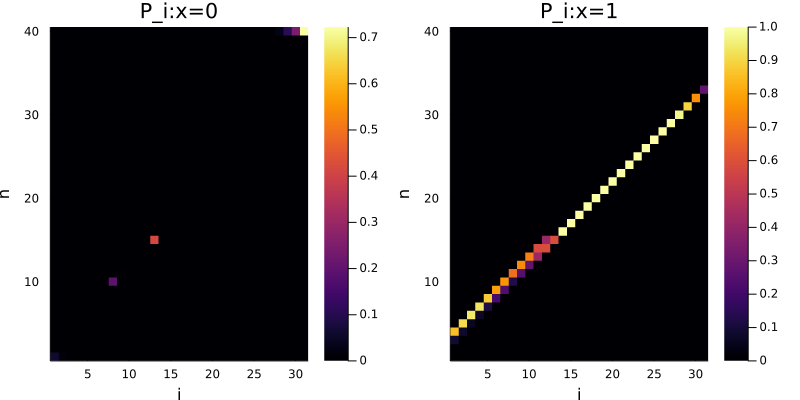

In [42]:
p0 = heatmap(bel_ϵ[:,1,:], xlabel="i", ylabel="n", title="P_i:x=0")
p1 = heatmap(bel_ϵ[:,2,:], xlabel="i", ylabel="n", title="P_i:x=1")
p = plot(p0, p1, size=(800,400))

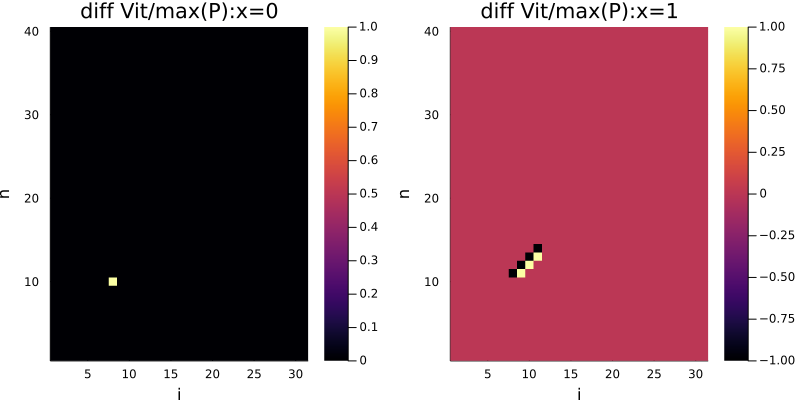

In [43]:
p2 = heatmap(t_vit[:,1,:] .- t_maxP[:,1,:], xlabel="i", ylabel="n", title="diff Vit/max(P):x=0")
p3 = heatmap(t_vit[:,2,:] .- t_maxP[:,2,:], xlabel="i", ylabel="n", title="diff Vit/max(P):x=1")
plot(p2,p3, size=(800,400))

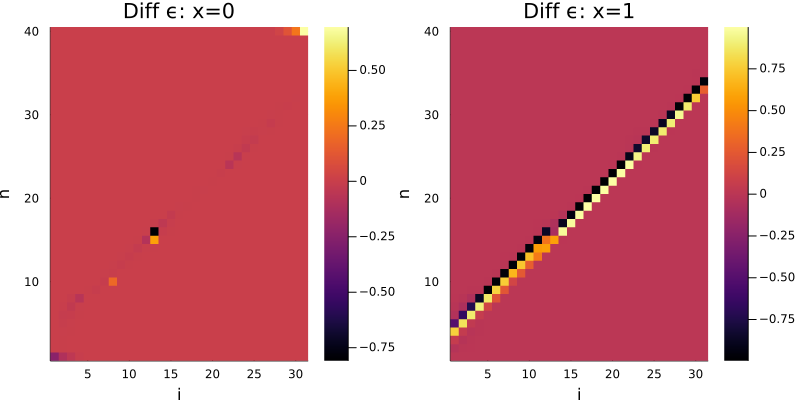

In [44]:
p00 = heatmap(bel_ϵ[:,1,:] .- bel_0[:,1,:], xlabel="i", ylabel="n", title="Diff ϵ: x=0")
p01 = heatmap(bel_ϵ[:,2,:] .- bel_0[:,2,:], xlabel="i", ylabel="n", title="Diff ϵ: x=1")
p = plot(p00, p01, size=(800,400))

In [45]:
#scatter(bel_0[:], bel_ϵ[:])

# -------------- Loop over sequences --------------

In [46]:
#build paramalgo
damp=T(0.9)
tol=T(1e-3)
tolnorm=T(1e-10)
tmax=10
upscheme=:sequential 
initcond=:random 
lr=:mf  
beta=T(0.0)
verbose=false
xnsol = fill((0, 0), L);
epscoupling=(false, T(0.0), xnsol)
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, initcond, lr, beta, verbose, epscoupling)

ParamAlgo{Float32}
-------------
damp=0.9
tol=0.001
tolnorm=1.0e-10
tmax=10
upscheme=sequential
initcond=random
lr=mf
beta=0.0
verbose=false
epscoupling=false
-------------

In [47]:
nsamp=100
samps = rand(1:M, nsamp);
#samps = readdlm("run_GS_PF00684_n50_mf_maxP.txt");
#samps = Int.(samps[2,1:50])

In [50]:
length(samps |> unique)

100

In [51]:
betas_seq = []
errs_seq = []
polars_seq = []

check_seq = []
ens_seq = []
ens_nucleation = []
ens_viterbi = []
U_seq = []
S_seq = []

xnsols_seq = fill((0, 0), L, nsamp)
xnsols_nucleation = fill((0, 0), L, nsamp)
xnsols_viterbi = fill((0, 0), L, nsamp)
#bels_seq = zeros(Nmax+2,2,L, nsamp);

In [52]:
#for (i,idx0) in pairs(samps)
#    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
#    N = length(al[idx0][2])
#    @show i, idx0, N
#end    

In [ ]:
iters = 700
minpol = 0.90
nmax = 30
minbet = 0.01


for (i,idx0) in pairs(samps)
    @show i, idx0

    #build seq, pm
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)
    @show seq
    
    #build BP fields
    bpm = BPMessages(seq, pm, pa)
    bpb = BPBeliefs(N, L)
    lrf = LongRangeFields(N, L)
    af = AllFields(bpm, bpb, lrf)
    
    #find ground state
    pa.beta = 0.0
    @time beta, err, polar, energy, check, U, S, xnsol, bel = BpAlignGpu.findGS(af, pm, pa, seq, iters = iters, minpol = minpol, nmax = nmax, minbet = minbet)    

    #decimation using nucleation
    P = fill(fill(0.0, 0:1,0:N+1), L)
    BpAlignGpu.reshape_T3(bel,P)
    s, P = BpAlignGpu.decimate_post(seq, P, L, q, N, false);
    seqsol_nucl = BpAlignGpu.decodeposterior(P, seq.strseq)
    sat = BpAlignGpu.check_assignment(P,false,N)
    if sat == false
        println("problem during nucleation")
        exit(0)
    end
    xnsol_nucl = BpAlignGpu.convertseqtoxnsol(seqsol_nucl, pm)
    energy_nucl = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol_nucl[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    
    #decimation using Viterbi
    xnsol_vit, p_vit = BpAlignGpu.viterbi_decoding(af, pm)
    seqsol_vit = BpAlignGpu.convert_soltosequence!(xnsol_vit, seq.strseq, N, L)
    energy_vit = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol_vit[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    c = BpAlignGpu.check_sr!(xnsol_vit, L, N)
    if sum(c) > 0
        println("problem during viterbi: new check=", sum(c))
        exit(0)
    end
    
    
    #store betas, convergence errors, energies and minimum polarizations
    append!(betas_seq, beta)
    append!(errs_seq, err)
    append!(polars_seq, polar)
    append!(ens_seq, energy)
    append!(check_seq, check)
    append!(U_seq, U)
    append!(S_seq, S)
    append!(ens_nucleation, energy_nucl)
    append!(ens_viterbi, energy_vit)
    
    #compute solution:
    xnsols_seq[:,i] = xnsol
    xnsols_nucleation[:,i] = xnsol_nucl
    xnsols_viterbi[:,i] = xnsol_vit
    #bels_seq[1:N+2,:,:,i] = bel
    
    println("\n")
end

(i, idx0) = (1, 18171)
seq = LPDNWEMAYTET-GEVYFIDHNTKTTSWLDP
DPLGPLPDNWEMAYTETGEVYFIDHNTKTTSWLDPRCLDK
beta = 0.0f0
converged: err=0.000998728, tol=0.001, nbiter=54
(polar, energy) = (0.03804766f0, 47.167423f0)
beta = 0.1
converged: err=0.00096586347, tol=0.001, nbiter=40
(polar, energy) = (0.05072124f0, 31.155758f0)
beta = 0.2
converged: err=0.000992626, tol=0.001, nbiter=43
(polar, energy) = (0.07206149f0, 16.761837f0)
beta = 0.30000000000000004
converged: err=0.0009717643, tol=0.001, nbiter=43
(polar, energy) = (0.10512839f0, -26.137852f0)
beta = 0.4
converged: err=0.0009821653, tol=0.001, nbiter=266
(polar, energy) = (0.84282655f0, -59.904385f0)
beta = 0.5
converged: err=0.000983119, tol=0.001, nbiter=59
(polar, energy) = (0.94144696f0, -59.904385f0)
 61.317591 seconds (29.40 M allocations: 1.543 GiB, 2.80% gc time, 25.82% compilation time)


(i, idx0) = (2, 6912)
seq = LPPGWEKRMSRSSGRVYYFNHMTNASQWERP
ADEEKLPPGWEKRMSRSSGRVYYFNHMTNASQWERPIAGGK
beta = 0.0f0
converged: err=0.000991635,

converged: err=0.0009947419, tol=0.001, nbiter=51
(polar, energy) = (0.95240176f0, -61.343433f0)
 39.155605 seconds (25.98 M allocations: 1.340 GiB, 3.75% gc time)


(i, idx0) = (11, 48892)
seq = ----WSEHVAPD-GRIYYYNADDKQSVWEKP
TGPPRALWSEHVAPDGRIYYYNADDKQSVWEKPSVLKS
beta = 0.0f0
converged: err=0.0009957477, tol=0.001, nbiter=61
(polar, energy) = (0.04087944f0, 38.21952f0)
beta = 0.1
converged: err=0.000971064, tol=0.001, nbiter=42
(polar, energy) = (0.05381339f0, 46.87875f0)
beta = 0.2
converged: err=0.0009941459, tol=0.001, nbiter=45
(polar, energy) = (0.07487441f0, 16.31144f0)
beta = 0.30000000000000004
converged: err=0.0009713471, tol=0.001, nbiter=47
(polar, energy) = (0.10950129f0, -34.81385f0)
beta = 0.4
converged: err=0.0009963512, tol=0.001, nbiter=240
(polar, energy) = (0.88179374f0, -63.573265f0)
beta = 0.5
converged: err=0.0009689331, tol=0.001, nbiter=67
(polar, energy) = (0.9478219f0, -63.573265f0)
 31.388347 seconds (26.07 M allocations: 1.341 GiB, 3.45% gc time)


(i, id

converged: err=0.0009768903, tol=0.001, nbiter=46
(polar, energy) = (0.107127704f0, -30.181961f0)
beta = 0.4
converged: err=0.0009966791, tol=0.001, nbiter=277
(polar, energy) = (0.8290986f0, -54.507298f0)
beta = 0.5
converged: err=0.0009884685, tol=0.001, nbiter=67
(polar, energy) = (0.9221911f0, -54.507298f0)
 39.729360 seconds (27.04 M allocations: 1.407 GiB, 2.64% gc time)


(i, idx0) = (21, 5232)
seq = LPPGWEERIHLD-GRTFYIDHNSKITQWEDP
NDLGPLPPGWEERIHLDGRTFYIDHNSKITQWEDPRLQNP
beta = 0.0f0
converged: err=0.0009974092, tol=0.001, nbiter=58
(polar, energy) = (0.038737867f0, 40.271526f0)
beta = 0.1
converged: err=0.0009791553, tol=0.001, nbiter=39
(polar, energy) = (0.051094085f0, 21.168858f0)
beta = 0.2
converged: err=0.0009755194, tol=0.001, nbiter=43
(polar, energy) = (0.07236634f0, 11.433783f0)
beta = 0.30000000000000004
converged: err=0.0009807944, tol=0.001, nbiter=41
(polar, energy) = (0.10396765f0, -26.944857f0)
beta = 0.4
converged: err=0.0009810328, tol=0.001, nbiter=254
(pola

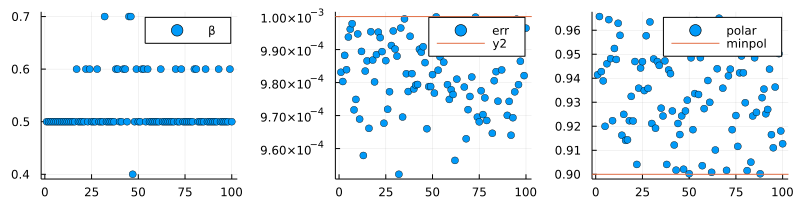

In [54]:
pb = scatter(1:nsamp, betas_seq, label="β")
per = scatter(1:nsamp, errs_seq, label="err")
hline!([pa.tol])
pp = scatter(1:nsamp, polars_seq, label = "polar")
hline!([minpol], label="minpol")
p = plot(pb, per, pp, layout=(1,3), size=(800,200))

In [55]:
ens_seq

100-element Vector{Any}:
 -59.904385f0
 -66.16211f0
 -63.768814f0
 -57.632473f0
 -53.078293f0
 -61.70038f0
 -70.336174f0
 -65.6446f0
 -70.29106f0
 -61.343433f0
 -63.573265f0
 -60.596474f0
 -61.64509f0
   ⋮
 -53.751812f0
 -61.810257f0
 -56.71604f0
 -59.005424f0
 -49.885994f0
 -55.05312f0
 -55.02457f0
 -61.13171f0
 -59.165825f0
 -63.664116f0
 -43.125656f0
 -54.6106f0

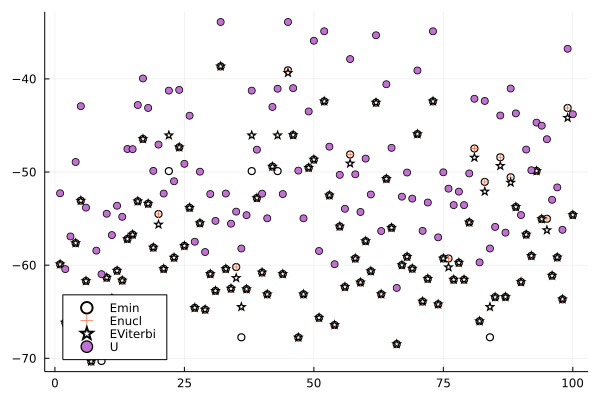

In [56]:
pen = scatter(1:nsamp, ens_seq, label="Emin", m=:circle, c=:white, msw=1.5)
scatter!(1:nsamp, ens_nucleation, label="Enucl", m=:+, msw=1.5)
scatter!(1:nsamp, ens_viterbi, label="EViterbi", m=:star, c=:white, msw=1.5)
scatter!(1:nsamp, U_seq, label="U", legend=:bottomleft)


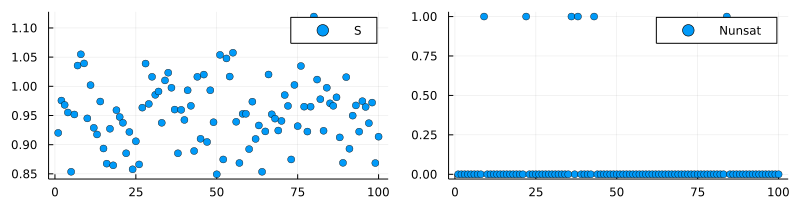

In [57]:
ps = scatter(1:nsamp, S_seq, label="S")
pc = scatter(1:nsamp, check_seq, label="Nunsat")
plot(ps, pc, layout=(1,2), size=(800,200))

In [58]:
n_PmaxgivesSol = sum(check_seq .== 0), findall(check_seq .!= 0)

(94, [9, 22, 36, 38, 43, 84])

In [59]:
findall(ens_nucleation .> ens_seq), findall(ens_viterbi .> ens_seq), findall(ens_viterbi .> ens_nucleation)

([9, 22, 36, 38, 43, 84], [9, 22, 36, 38, 43, 84], Int64[])

In [60]:
sum(ens_nucleation .< ens_seq), sum(ens_nucleation .== ens_seq), sum(ens_nucleation .> ens_seq)

(0, 94, 6)

In [61]:
sum(ens_viterbi .< ens_seq), sum(ens_viterbi .== ens_seq), sum(ens_viterbi .> ens_seq)

(11, 83, 6)

In [62]:
sum(ens_viterbi .< ens_nucleation), sum(ens_viterbi .== ens_nucleation), sum(ens_viterbi .> ens_nucleation)

(11, 89, 0)

In [63]:
#using Plots
#i=1
#idx0 = samples[i]
#N = length(al[idx0][2])
#bel = bels_seq[1:N+2,:,:,i];
#p0 = heatmap(bel[:,1,:], xlabel="i", ylabel="n", title="x=0")
#p1 = heatmap(bel[:,2,:], xlabel="i", ylabel="n", title="x=1")
#p = plot(p0, p1, size=(500,250))

In [64]:
paramrun = [nsamp, fam, L, M, delta, pa.damp, pa.tol, pa.tolnorm, pa.initcond, pa.lr, iters, minpol, nmax, minbet]

14-element Vector{Any}:
   100
      "PF00397"
    31
 59696
     5
     0.9f0
     0.001f0
     1.0f-10
      :random
      :mf
   700
     0.9
    30
     0.01

In [65]:
namefile = "run_GS_"*String(fam)*"_n"*string(nsamp)*"_"*String(pa.lr)*"_maxP.txt"

open(namefile, "a") do io
    writedlm(io, [paramrun])
    writedlm(io, [samps])
end

for (i,idx0) in pairs(samps)
    x0 = [x[1] for x in xnsols_seq[:,i]]
    x1 = [x[2] for x in xnsols_seq[:,i]]
    xc = vcat(x0, x1)
    open(namefile, "a") do io
        writedlm(io, [xc])
    end
end


In [66]:
namefile = "run_GS_"*String(fam)*"_n"*string(nsamp)*"_"*String(pa.lr)*"_nucleation.txt"

open(namefile, "a") do io
    writedlm(io, [paramrun])
    writedlm(io, [samps])
end

for (i,idx0) in pairs(samps)
    x0 = [x[1] for x in xnsols_nucleation[:,i]]
    x1 = [x[2] for x in xnsols_nucleation[:,i]]
    xc = vcat(x0, x1)
    open(namefile, "a") do io
        writedlm(io, [xc])
    end
end


In [67]:
namefile = "run_GS_"*String(fam)*"_n"*string(nsamp)*"_"*String(pa.lr)*"_viterbi.txt"

open(namefile, "a") do io
    writedlm(io, [paramrun])
    writedlm(io, [samps])
end

for (i,idx0) in pairs(samps)
    x0 = [x[1] for x in xnsols_viterbi[:,i]]
    x1 = [x[2] for x in xnsols_viterbi[:,i]]
    xc = vcat(x0, x1)
    open(namefile, "a") do io
        writedlm(io, [xc])
    end
end


In [68]:
open("inds.txt", "a") do io
    writedlm(io, [samps])
end

In [49]:
#namefile = "run_GS_"*String(fam)*"_n"*string(nsamp)*"_"*String(pa.lr)*".txt"
#for (i,idx0) in pairs(samps)
#    @show i, idx0

#    #build seq, pm
#    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
#    N = length(al[idx0][2])
#    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)
    
#    seqsol = BpAlignGpu.convert_soltosequence!(xnsols_seq[:,i], seq.strseq, N, L)
#    r = [idx0, seqsol[1], seqsol[2], seqsol[3], seqsol[4]]
#    open(namefile, "a") do io
#               writedlm(io, [r])
#    end
    
#end

# -------------- $\epsilon$ increasing --------------

In [69]:
#build paramalgo
damp=T(0.9)
tol=T(1e-3)
tolnorm=T(1e-10)
tmax=10
upscheme=:sequential 
initcond=:random 
lr=:mf  
beta=T(0.0)
verbose=false
xnsol = fill((0, 0), L);
epscoupling=(false, T(0.0), xnsol)
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, initcond, lr, beta, verbose, epscoupling)

ParamAlgo{Float32}
-------------
damp=0.9
tol=0.001
tolnorm=1.0e-10
tmax=10
upscheme=sequential
initcond=random
lr=mf
beta=0.0
verbose=false
epscoupling=false
-------------

In [70]:
epsilons = [-0.0, -0.1, -0.2, -0.3,-0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0, -1.5]

12-element Vector{Float64}:
 -0.0
 -0.1
 -0.2
 -0.3
 -0.4
 -0.5
 -0.6
 -0.7
 -0.8
 -0.9
 -1.0
 -1.5

In [71]:
length(epsilons)

12

In [72]:
nsamp

100

In [73]:
betas_seq_eps = zeros(length(epsilons), nsamp)
errs_seq_eps = zeros(length(epsilons), nsamp)
polars_seq_eps = zeros(length(epsilons), nsamp)
ens_seq_eps = zeros(length(epsilons), nsamp)
U_seq_eps = zeros(length(epsilons), nsamp)
S_seq_eps = zeros(length(epsilons), nsamp)
check_seq_eps = zeros(length(epsilons), nsamp)

xnsols_seq_eps = fill((0,0), L, length(epsilons), nsamp);
#bels_seq_eps = ones(Nmax+2,2,L, length(epsilons), nsamp);

In [74]:
iters = 1000

minpol = 0.90
nmax = 30
minbet = 0.02

#betarange = 0.0:0.05:0.5
#minpol = 1.0 (to make sure that it didnt stop before beta=0.5)

0.02

In [ ]:
for (i,idx0) in pairs(samps)

    #build seq, pm
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)
    
    xn = xnsols_viterbi[:,i] 
    for j in eachindex(epsilons)
        ϵ = epsilons[j]
        @show i, idx0, N, ϵ
        pa.epscoupling = (true, T(ϵ), xn)

        #build BP fields
        bpm = BPMessages(seq, pm, pa)
        bpb = BPBeliefs(N, L)
        lrf = LongRangeFields(N, L)
        af = AllFields(bpm, bpb, lrf)
        
        #find GS
        pa.beta = 0.0
        @time beta, err, polar, energy, check, U, S, xnsol, bel = BpAlignGpu.findGS(af, pm, pa, seq, iters = iters, minpol = minpol, nmax = nmax, minbet = minbet)
        #@time beta, err, polar, energy, check, U, S, xnsol, bel = BpAlignGpu.findGS_betarange(af, pm, pa, seq; iters=iters, betarange = betarange, minpol = minpol)
        
        #decimation using Viterbi
        xnsol, p_vit = BpAlignGpu.viterbi_decoding(af, pm)
        seqsol = BpAlignGpu.convert_soltosequence!(xnsol, seq.strseq, N, L)
        energy = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
        c = BpAlignGpu.check_sr!(xnsol, L, N)
        if sum(c) > 0
            println("problem during viterbi: new check=", sum(c))
            exit(0)
        end
 
        betas_seq_eps[j,i] = beta
        errs_seq_eps[j,i] = err
        polars_seq_eps[j,i] = polar
        ens_seq_eps[j,i] = energy
        U_seq_eps[j,i] = U
        S_seq_eps[j,i] = S
        check_seq_eps[j,i] = check

        #bels_seq_eps[1:N+2, :, :, j, i] = bel
        xnsols_seq_eps[:,j,i] = xnsol
        @show i, idx0, ϵ, energy, U
        println("\n")
    end
    println("\n")
end


(i, idx0, N, ϵ) = (1, 18171, 40, -0.0)
beta = 0.0f0
converged: err=0.0009975731, tol=0.001, nbiter=59
(polar, energy) = (0.038952444f0, 34.476963f0)
beta = 0.1
converged: err=0.0009773374, tol=0.001, nbiter=41
(polar, energy) = (0.051871307f0, 23.178997f0)
beta = 0.2
converged: err=0.0009646714, tol=0.001, nbiter=44
(polar, energy) = (0.07361741f0, 11.918398f0)
beta = 0.30000000000000004
converged: err=0.0009900033, tol=0.001, nbiter=42
(polar, energy) = (0.10692023f0, -26.137852f0)
beta = 0.4
converged: err=0.0009921789, tol=0.001, nbiter=264
(polar, energy) = (0.8428897f0, -59.904385f0)
beta = 0.5
converged: err=0.000982821, tol=0.001, nbiter=59
(polar, energy) = (0.9414503f0, -59.904385f0)
 28.913325 seconds (26.04 M allocations: 1.348 GiB, 3.06% gc time)
(i, idx0, ϵ, energy, U) = (1, 18171, -0.0, -59.904385f0, -52.28232f0)


(i, idx0, N, ϵ) = (1, 18171, 40, -0.1)
beta = 0.0f0
converged: err=0.0009949431, tol=0.001, nbiter=58
(polar, energy) = (0.038606945f0, 37.15752f0)
beta = 0.1


converged: err=0.0009866953, tol=0.001, nbiter=47
(polar, energy) = (0.12677737f0, 10.66779f0)
beta = 0.5
converged: err=0.0009998977, tol=0.001, nbiter=59
(polar, energy) = (0.17105386f0, 13.005964f0)
beta = 0.6
converged: err=0.0009956956, tol=0.001, nbiter=90
(polar, energy) = (0.23928496f0, 11.868219f0)
beta = 0.7
converged: err=0.0009962916, tol=0.001, nbiter=82
(polar, energy) = (0.30181232f0, 0.41891602f0)
beta = 0.7999999999999999
converged: err=0.0009752512, tol=0.001, nbiter=31
(polar, energy) = (0.3240076f0, 0.41891602f0)
beta = 0.8999999999999999
converged: err=0.0009649992, tol=0.001, nbiter=26
(polar, energy) = (0.34203583f0, -0.67946756f0)
beta = 0.9999999999999999
converged: err=0.000983566, tol=0.001, nbiter=142
(polar, energy) = (0.37663242f0, -1.2162399f0)
beta = 1.0999999999999999
converged: err=0.000978589, tol=0.001, nbiter=424
(polar, energy) = (0.98227245f0, -59.904385f0)
 74.290889 seconds (56.98 M allocations: 2.944 GiB, 3.58% gc time, 4.04% compilation time)


In [81]:
ens_seq_eps[:,5]

12-element Vector{Float64}:
 -60.5162239074707
 -60.5162239074707
 -60.5162239074707
 -60.5162239074707
 -60.5162239074707
 -60.5162239074707
 -60.5162239074707
 -60.5162239074707
 -60.5162239074707
 -60.5162239074707
 -60.5162239074707
 -60.5162239074707

In [63]:
errs_seq_eps
mask_errs = (errs_seq_eps .<0.01)
nb_converged = sum(mask_errs, dims=2)

12×1 Matrix{Int64}:
 100
 100
 100
 100
 100
 100
 100
  99
  99
  99
 100
  98

In [60]:
mask = (check_seq_eps .== 0.0)
nbsol_mean = [mean(mask[j,:]) for j in eachindex(epsilons)]
nbsol_std = [std(mask[j,:]) for j in eachindex(epsilons)]./sqrt(nsamp);
nbsol_mean

12-element Vector{Float64}:
 0.92
 0.9
 0.91
 0.91
 0.91
 0.93
 0.94
 0.93
 0.91
 0.88
 0.9
 0.84

In [64]:
findall( [!(xnsols_viterbi[:,i] == xnsols_seq_eps[:,1,i]) for i in 1:nsamp])

5-element Vector{Int64}:
 52
 53
 56
 97
 99

In [65]:
mΔEs = []
vΔEs = []
mΔUs = []
vΔUs = []
mΔdist = []
vΔdist = []
for j in eachindex(epsilons)
    ΔE = []
    ΔU = []
    Δi = []
    for i in 1:nsamp
        if mask_errs[j,i]
            dE = (ens_seq_eps[j,i] - ens_seq_eps[1,i])
            append!(ΔE, dE)
            dU = (U_seq_eps[j,i] - U_seq_eps[1,i])
            append!(ΔU, dU)
            di = sum(xnsols_seq_eps[:,j,i] .!= xnsols_seq_eps[:,1,i])/L
            append!(Δi, di)
        end
    end
    append!(mΔEs, mean(ΔE))
    append!(vΔEs, std(ΔE)/sqrt(nb_converged[j]))
    append!(mΔUs, mean(ΔU))
    append!(vΔUs, std(ΔU)/sqrt(nb_converged[j]))
    append!(mΔdist, mean(Δi))
    append!(vΔdist, std(Δi)/sqrt(nb_converged[j]))
end

In [70]:
epsilons

12-element Vector{Float64}:
 -0.0
 -0.1
 -0.2
 -0.3
 -0.4
 -0.5
 -0.6
 -0.7
 -0.8
 -0.9
  1.0
 -1.2

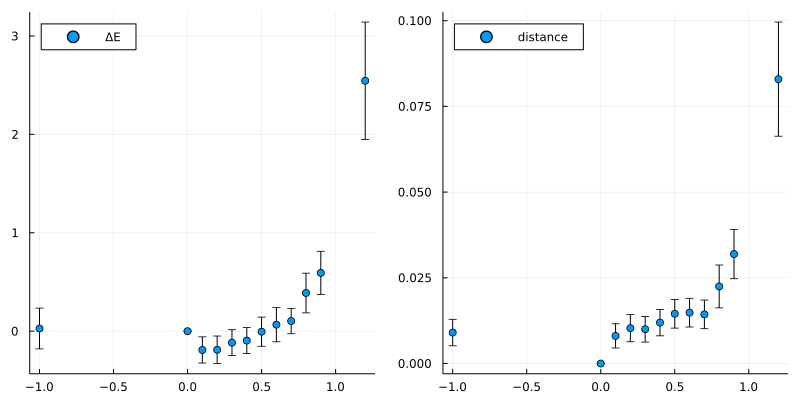

In [69]:
pΔ = scatter(-epsilons, mΔEs, yerr=vΔEs, label="ΔE", legend=:topleft)
#scatter!(-epsilons, mΔUs, yerr=vΔUs, label="ΔU")
pdist = scatter(-epsilons, mΔdist, yerr=vΔdist, label="distance", legend=:topleft)
plot(pΔ, pdist, size=(800,400))

In [67]:
mE = []
vE = []
mU = []
vU = []
mS = []
vS = []
for j in eachindex(epsilons)
    EE = []
    UU = []
    SS = []
    for i in 1:nsamp
        if mask_errs[j,i]
            append!(EE, ens_seq_eps[j,i])
            append!(UU, U_seq_eps[j,i])
            append!(SS, S_seq_eps[j,i])
        end
    end
    append!(mE, mean(EE))
    append!(vE, std(EE)/sqrt(nb_converged[j]))
    append!(mU, mean(UU))
    append!(vU, std(UU)/sqrt(nb_converged[j]))
    append!(mS, mean(SS))
    append!(vS, std(SS)/sqrt(nb_converged[j]))
end

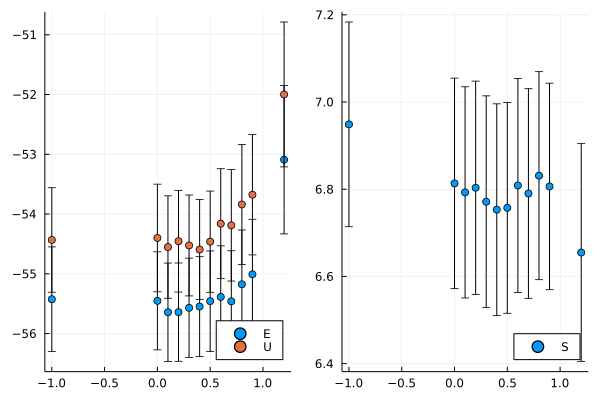

In [68]:
pu = scatter(-epsilons, mE, yerr=vE, label="E", legend=:bottomright)
scatter!(-epsilons, mU, yerr=vU, label="U", legend=:bottomright)
ps = scatter(-epsilons, mS, yerr=vS, label="S", legend=:bottomright)
plot(pu, ps)

In [71]:
μbetas = [mean(betas_seq_eps[j,:]) for j in eachindex(epsilons)]
σbetas = [std(betas_seq_eps[j,:]) for j in eachindex(epsilons)]./sqrt(nsamp)
μerrs = [mean(errs_seq_eps[j,:]) for j in eachindex(epsilons)]
σerrs = [std(errs_seq_eps[j,:]) for j in eachindex(epsilons)]./sqrt(nsamp);

In [72]:
mpolars = []
vpolars = []
for j in eachindex(epsilons)
    pols = []
    for i in 1:nsamp
        if mask_errs[j,i]
            append!(pols, polars_seq_eps[j,i])
        end
    end
    append!(mpolars, mean(pols))
    append!(vpolars, std(pols)/sqrt(nb_converged[j]))
end

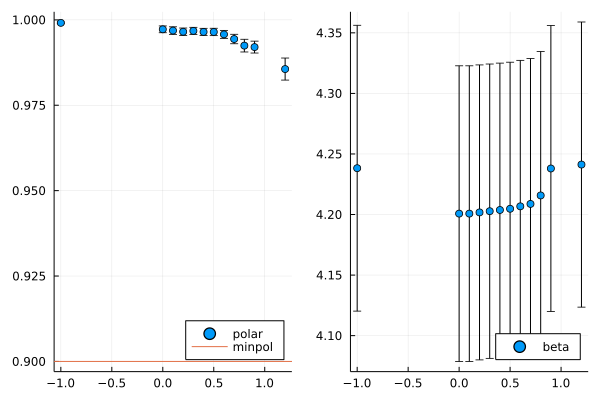

In [73]:
pp = scatter(-epsilons, mpolars, yerr=vpolars, label="polar", legend=:bottomright)
hline!([minpol], label="minpol")
pb = scatter(-epsilons, μbetas, yerr=σbetas, label="beta", legend=:bottomright)
plot(pp, pb)

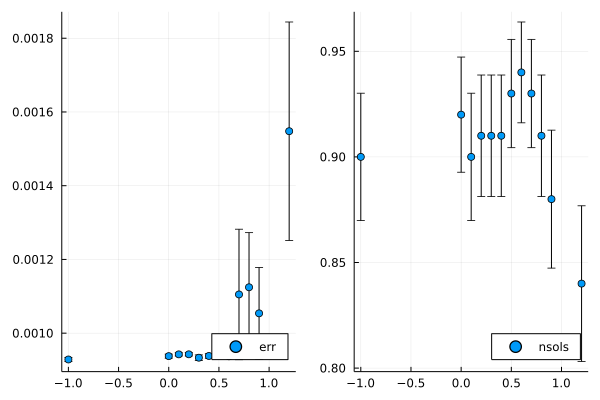

In [74]:
pe = scatter(-epsilons, μerrs, yerr=σerrs, label="err", legend=:bottomright)
pnunsat = scatter(-epsilons, nbsol_mean, yerr=nbsol_std, label="nsols", legend=:bottomright)
plot(pe, pnunsat)

In [76]:
#paramrun = [nsamp, fam, L, M, delta, pa.damp, pa.tol, pa.tolnorm, pa.initcond, pa.lr, iters, betamax]
paramrun = [nsamp, fam, L, M, delta, pa.damp, pa.tol, pa.tolnorm, pa.initcond, pa.lr, iters, minpol, nmax, minbet]

14-element Vector{Any}:
   100
      "PF00397"
    31
 59696
     5
     0.9f0
     0.001f0
     1.0f-10
      :random
      :mf
  2000
     0.9
    30
     0.02

In [77]:
namefile

"run_GS_PF00397_n100_mf_viterbi.txt"

In [187]:
namefile = "run_epsilon_"*String(fam)*"_"*String(pa.lr)*"_"*string(nsamp)*"_betafixed.txt"
open(namefile, "a") do io
    writedlm(io, [paramrun])
end

open(namefile, "a") do io
    writedlm(io, [epsilons])

    writedlm(io, [mΔEs])
    writedlm(io, [vΔEs])
    writedlm(io, [mΔUs])
    writedlm(io, [vΔUs])
    writedlm(io, [mΔdist])
    writedlm(io, [vΔdist])
    
    writedlm(io, [mE])
    writedlm(io, [vE])
    writedlm(io, [mU])
    writedlm(io, [vU])
    writedlm(io, [mS])
    writedlm(io, [vS])
    
    writedlm(io, [mpolars])
    writedlm(io, [vpolars])
    writedlm(io, [μbetas])
    writedlm(io, [σbetas])
    writedlm(io, [μerrs])
    writedlm(io, [σerrs])

    writedlm(io, [nbsol_mean])
    writedlm(io, [nbsol_std])
end
